# QuTiP example: Nonlinear Response of the Vacuum Rabi Resonance
Akash Levy and Katie Blume

For more information about QuTiP see http://qutip.org

## Setup

In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from qutip import *

In [3]:
# Fundamental constants
eps0 = 8.854E-12                        # Vacuum permittivity (F/m)
c = 2.998E8                             # Speed of light (m/s)
hb = 1.0545718E-34                      # Planck's constant (J s)
e = -1.6021766E-19                      # Electron charge (C)

In [4]:
# System parameters
omega_r = 6.92E9 * 2 * np.pi            # Resonator frequency
omega_C1 = 400E6 * 2 * np.pi            # Frequency associated with charging energy of qubit 1
omega_C2 = 340E6 * 2 * np.pi            # Frequency associated with charging energy of qubit 2
omega_J = omega_r                       # Frequency associated with Josephson energy

g0_q1 = 347E6 * np.pi                   # Ground state coupling coefficient for qubit 1
g0_q2 = 94.4E6 * np.pi                  # Ground state coupling coefficient for qubit 2

T_1 = 12 * np.pi * eps0 * hb * c**3
T_1 /= (2 * e * 15E-6)**2 * omega_r**3
gamma_1 = 1 / T_1                       # Rate of intrinsic relaxation of transmon excitations
gamma_phi = 0                           # Rate of pure dephasing of cavity photons (unused, ignored)
kappa = 300E3 * 2 * np.pi               # Rate of loss of cavity photons
alpha = - omega_C1                      # Anharmonicity of JC ladder (to first order)

In [5]:
# Dummy system parameters (for testing, comment out)
kappa = 0.05
gamma_1 = 0.01
omega_r = omega_C1 = omega_J = 2 * np.pi
g0_q1 = 0.1 * 2 * np.pi
alpha = omega_C1

In [6]:
# Helper functions
def g_j(j):
    return g0_q1 * np.sqrt(j+1)
def alpha_j(j):
    return g_j(j) / g0_q1
def omega_j(j):
    return np.sqrt(8 * omega_C1 * omega_J) * (j + 1./2) - omega_C1 / 12 * (6*j**2 + 6*j + 3) - omega_J
def j_braket(j1,j2):
    if j1 >= N_atom or j2 >= N_atom:
        return tensor(qeye(N_light), identity(N_atom)-identity(N_atom))
    return tensor(qeye(N_light), fock(N_atom, j1) * fock(N_atom, j2).dag())

In [7]:
# Simulation parameters
N_light = 5
N_atom = 2

## Figure 2: Supersplitting of the vacuum Rabi resonance when probing heterodyne transmission beyond linear response

In [8]:
# Vary the driving force
xi_dbs = np.linspace(-40, 0, 41)                # Driving strengths
omega_ds = np.linspace(0, 2, 200) * 2 * np.pi   # Driving frequencies

-40.0 dB


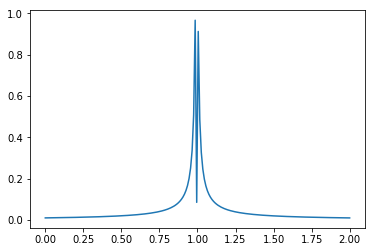

-30.0 dB


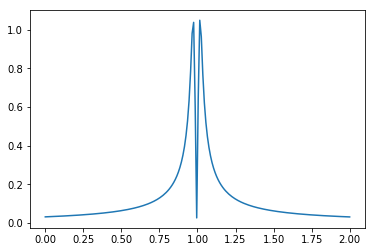

-20.0 dB


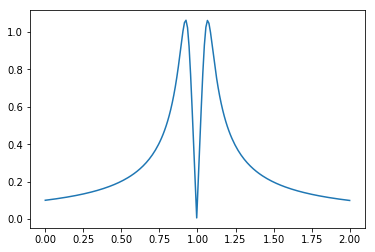

-10.0 dB


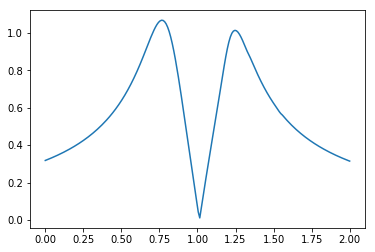

0.0 dB


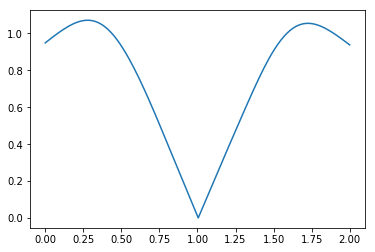

In [9]:
# Find transmission amplitude for varying frequencies
results = []
for xi_db in xi_dbs:
    # Convert decibel to magnitude
    xi = 10**(xi_db/20)*omega_r

    # Operators
    a = tensor(destroy(N_light), qeye(N_atom))
    sm = tensor(qeye(N_light), destroy(N_atom))
    
    # Solve master equation for different driving frequencies
    results.append([])
    for omega_d in omega_ds:
        # Hamiltonian
        H_res = (omega_r-omega_d) * a.dag() * a
        H_qub = sum([omega_j(j) * j_braket(j,j) for j in range(N_atom)])
        H_int = sum([g_j(j) * (a * j_braket(j+1,j) + j_braket(j,j+1) * a.dag()) for j in range(N_atom)])
        H_drv = xi * (a.dag() + a)
        H = H_res + H_qub + H_int + H_drv

        # Collapse operators
        damping = kappa * a
        relaxation = gamma_1 * sum([alpha_j(j) * j_braket(j,j+1) for j in range(N_atom-1)])
        c_ops = [damping, relaxation]
        
        # Steady-state solution of master equation
        rho_s = steadystate(H, c_ops)
        results[-1].append(np.abs(expect(a, rho_s)))
        passing = True

    # Plot results
    if int(xi_db) % 10 == 0:
        print xi_db, "dB"
        plt.plot(omega_ds/(2*np.pi), results[-1])
        plt.show()

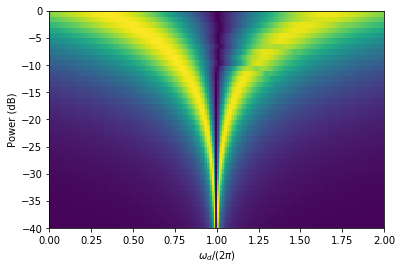

In [10]:
# Generate pseudocolor plot of transmission amplitude response over parameter space
plt.xlabel('$\omega_d / (2 \pi)$')
plt.ylabel('Power (dB)')
plt.pcolor(omega_ds/(2*np.pi), xi_dbs, results)
plt.show()

## Versions

In [11]:
from qutip.ipynbtools import version_table

version_table()

Software,Version
QuTiP,4.2.0
Numpy,1.14.0
SciPy,1.0.0
matplotlib,2.1.2
Cython,0.27.3
Number of CPUs,2
BLAS Info,INTEL MKL
IPython,5.4.1
Python,"2.7.14 |Anaconda, Inc.| (default, Dec 7 2017, 11:07:58) [GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]"
OS,posix [darwin]
